# Mô hình phân loại động vật

## Import library

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from datetime import datetime
from pathlib import Path
from collections import Counter
import gc
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [ ]:
# Cấu hình 
CONFIG = {
    'IMG_SIZE': 64,
    'BATCH_SIZE': 128,
    'TEST_SIZE': 0.15,
    'VAL_SIZE': 0.15,
    'RANDOM_STATE': 42,
    'EPOCHS': 30,
    'LEARNING_RATE': 0.001,
    'EARLY_STOP_PATIENCE': 5,
    'LR_REDUCE_PATIENCE': 3,
    'DATASET_DIR': 'datasets',
    'MODEL_PATH': 'model.h5',
    'CLASSES_PATH': 'class_names.npy',
    'STATS_PATH': 'normalization_stats.npy',
    'WORKERS': 1,
    'USE_MULTIPROCESSING': False,
}



CPU-Optimized Configuration:
 • IMG_SIZE                 : 64
 • BATCH_SIZE               : 128
 • TEST_SIZE                : 0.15
 • VAL_SIZE                 : 0.15
 • RANDOM_STATE             : 42
 • EPOCHS                   : 30
 • LEARNING_RATE            : 0.001
 • EARLY_STOP_PATIENCE      : 5
 • LR_REDUCE_PATIENCE       : 3
 • DATASET_DIR              : datasets
 • MODEL_PATH               : model.h5
 • CLASSES_PATH             : class_names.npy
 • STATS_PATH               : normalization_stats.npy
 • WORKERS                  : 1
 • USE_MULTIPROCESSING      : False


## Load dữ liệu ảnh

In [13]:
print("\nĐang load dữ liệu...")
start_time = datetime.now()

dataset_dir = Path(CONFIG['DATASET_DIR'])
IMG_SIZE = CONFIG['IMG_SIZE']
VALID_EXT = ('.jpg', '.jpeg', '.png', '.bmp')

images = []
labels = []
class_names = []

for class_dir in sorted(dataset_dir.iterdir()):
    if not class_dir.is_dir():
        continue
    class_name = class_dir.name
    class_names.append(class_name)
    image_files = [f for f in class_dir.iterdir() if f.suffix.lower() in VALID_EXT]
    print(f" • {class_name:15s}: {len(image_files):5d} ảnh", end="")
    
    for img_path in image_files:
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
        labels.append(class_name)
    print(" Done")

images = np.array(images, dtype='uint8')  # uint8 để tiết kiệm RAM
labels = np.array(labels)

elapsed = (datetime.now() - start_time).total_seconds()
print(f"Total: {len(images):,} ảnh | {len(class_names)} classes")
print(f"Memory: {images.nbytes / (1024**2):.1f} MB")


Đang load dữ liệu...
 • butterfly      :  2112 ảnh Done
 • cat            :  1668 ảnh Done
 • chicken        :  3098 ảnh Done
 • cow            :  1866 ảnh Done
 • dog            :  4863 ảnh Done
 • elephant       :  1446 ảnh Done
 • horse          :  2623 ảnh Done
 • sheep          :  1820 ảnh Done
 • spider         :  4821 ảnh Done
 • squirrel       :  1862 ảnh Done

Load hoàn tất trong 382.8s
Total: 26,179 ảnh | 10 classes
Memory: 306.8 MB


## Tiền xử lý dữ liệu

In [14]:
print("\nTiền xử lý...")

# Chuẩn hóa đơn giản: /255
images = images.astype('float32') / 255.0

# Lưu method
np.save(CONFIG['STATS_PATH'], {'method': 'divide_255'})
print(" • Normalization: /255")

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)
print(f" • Labels: {labels_categorical.shape}")

# Phân bố class
print("\nPhân bố classes:")
class_counts = Counter(labels)
for cls, count in sorted(class_counts.items()):
    bar = '█' * int(count // 100)
    print(f" {cls:12s} [{count:5d}] {bar}")


Tiền xử lý...
 • Normalization: /255
 • Labels: (26179, 10)

Phân bố classes:
 butterfly    [ 2112] █████████████████████
 cat          [ 1668] ████████████████
 chicken      [ 3098] ██████████████████████████████
 cow          [ 1866] ██████████████████
 dog          [ 4863] ████████████████████████████████████████████████
 elephant     [ 1446] ██████████████
 horse        [ 2623] ██████████████████████████
 sheep        [ 1820] ██████████████████
 spider       [ 4821] ████████████████████████████████████████████████
 squirrel     [ 1862] ██████████████████


## Chia tập dữ liệu

In [15]:
print("\nChia dữ liệu...")

X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels_categorical,
    test_size=CONFIG['TEST_SIZE'] + CONFIG['VAL_SIZE'],
    stratify=labels_encoded,
    random_state=CONFIG['RANDOM_STATE']
)

val_ratio = CONFIG['VAL_SIZE'] / (CONFIG['TEST_SIZE'] + CONFIG['VAL_SIZE'])
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=1 - val_ratio,
    stratify=np.argmax(y_temp, axis=1),
    random_state=CONFIG['RANDOM_STATE']
)

print(f" Train: {X_train.shape[0]:6,} ({X_train.shape[0]/len(images)*100:5.1f}%)")
print(f" Val  : {X_val.shape[0]:6,} ({X_val.shape[0]/len(images)*100:5.1f}%)")
print(f" Test : {X_test.shape[0]:6,} ({X_test.shape[0]/len(images)*100:5.1f}%)")

del images, labels, labels_categorical, X_temp, y_temp
gc.collect()
print(" Memory cleaned")


Chia dữ liệu...
 Train: 18,325 ( 70.0%)
 Val  :  3,927 ( 15.0%)
 Test :  3,927 ( 15.0%)
 Memory cleaned


## Xây dựng mô hình CNN

In [ ]:
# Xây dựng mô hình CNN
def create_lightweight_cnn(input_shape, num_classes):
    model = Sequential([
        
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        GlobalAveragePooling2D(),

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_lightweight_cnn((IMG_SIZE, IMG_SIZE, 3), len(class_names))
model.compile(
    optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
model.summary()
print(f"\nTotal params: {model.count_params():,} | Phù hợp CPU")


Xây dựng Lightweight CNN...

Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 

In [ ]:
# Thiết lập callbacks
print("\nThiết lập callbacks...")
callbacks = [
    ModelCheckpoint(CONFIG['MODEL_PATH'], monitor='val_accuracy', mode='max', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=CONFIG['EARLY_STOP_PATIENCE'], restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=CONFIG['LR_REDUCE_PATIENCE'], min_lr=1e-6, verbose=1)
]

for cb in callbacks:
    print(f" • {cb.__class__.__name__}")


Thiết lập callbacks...
 • ModelCheckpoint
 • EarlyStopping
 • ReduceLROnPlateau


## Trainning

In [24]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=CONFIG['BATCH_SIZE'],
    epochs=CONFIG['EPOCHS'],
    callbacks=callbacks,
    verbose=1,
    workers=CONFIG['WORKERS'],
    use_multiprocessing=CONFIG['USE_MULTIPROCESSING']
)


Epoch 1/30
 16/144 [==>...........................] - ETA: 49s - loss: 1.0831 - accuracy: 0.6328

KeyboardInterrupt: 

## Đồ thị 


Vẽ đồ thị...


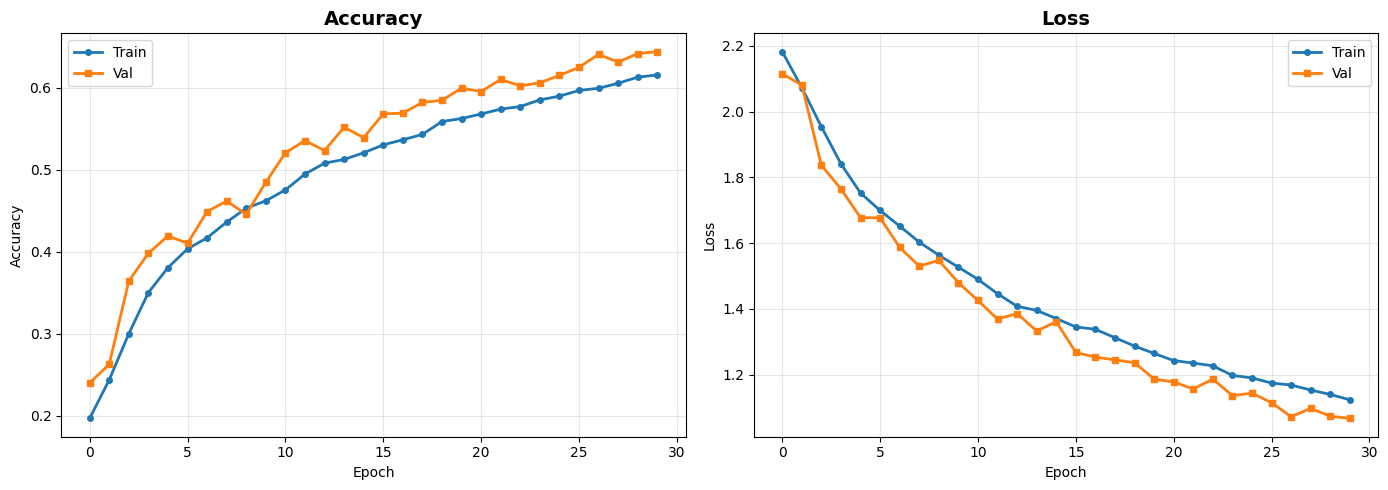

 Saved: training_history.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], 'o-', label='Train', linewidth=2, markersize=4)
axes[0].plot(history.history['val_accuracy'], 's-', label='Val', linewidth=2, markersize=4)
axes[0].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Accuracy')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], 'o-', label='Train', linewidth=2, markersize=4)
axes[1].plot(history.history['val_loss'], 's-', label='Val', linewidth=2, markersize=4)
axes[1].set_title('Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()
print(" Saved: training_history.png")

## Đánh giá test

In [ ]:
# Đánh giá test set
y_pred_probs = model.predict(X_test, batch_size=CONFIG['BATCH_SIZE'], verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"\n{'='*50}")
print(f"TEST ACCURACY: {test_acc*100:.2f}%")
print(f"TEST LOSS    : {test_loss:.4f}")
print(f"{'='*50}\n")

print("Chi tiết từng class:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))


Đánh giá test set...
31/31 [==============================] - 3s 75ms/step

TEST ACCURACY: 64.12%
TEST LOSS    : 1.0232

Chi tiết từng class:

              precision    recall  f1-score   support

   butterfly      0.849     0.672     0.750       317
         cat      0.534     0.124     0.201       250
     chicken      0.706     0.802     0.751       465
         cow      0.547     0.314     0.399       280
         dog      0.600     0.693     0.643       729
    elephant      0.558     0.668     0.608       217
       horse      0.621     0.652     0.636       394
       sheep      0.510     0.549     0.529       273
      spider      0.710     0.907     0.797       723
    squirrel      0.513     0.358     0.422       279

    accuracy                          0.641      3927
   macro avg      0.615     0.574     0.574      3927
weighted avg      0.632     0.641     0.621      3927



## Confusion Matrix


Vẽ Confusion Matrix...


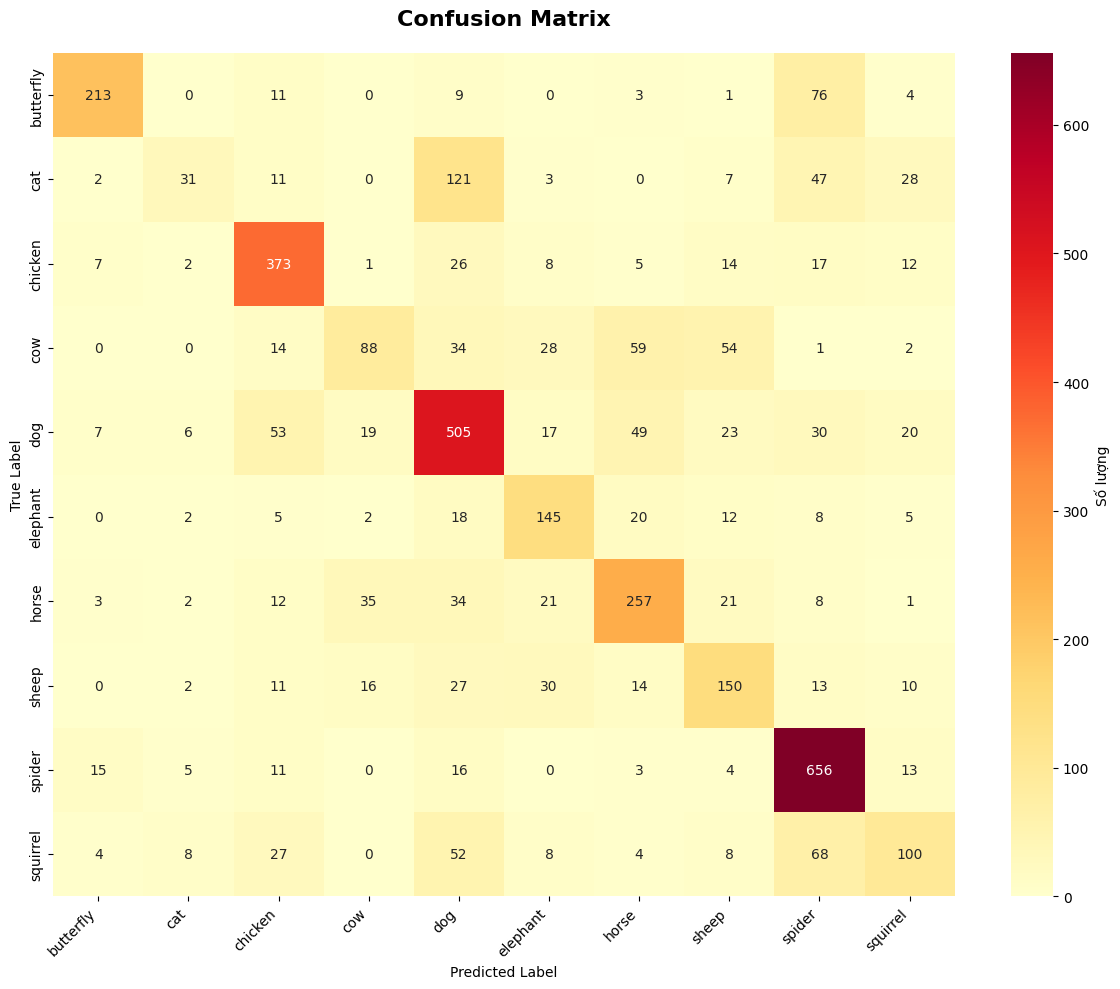

 Saved: confusion_matrix.png


In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Số lượng'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()
print(" Saved: confusion_matrix.png")

## Các file dữ liệu

In [ ]:
#  các file cần thiết
np.save(CONFIG['CLASSES_PATH'], class_names)
print(f" • {CONFIG['CLASSES_PATH']}")
print(f" • {CONFIG['MODEL_PATH']}")
print(f" • {CONFIG['STATS_PATH']}")

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print(" • training_history.pkl")


Lưu files...
 • class_names.npy
 • model.h5
 • normalization_stats.npy
 • training_history.pkl
